In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

print(tf.__version__)

2.4.0-rc0


In [52]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
    "font.size": 25,
})

In [5]:
def getData(n_instances,noise):
    b = np.random.rand(n_instances)
    x = np.linspace(0,1,20)
    x = b*x.repeat(n_instances).reshape((20,n_instances))
    
    X = 10*x**3 + noise*(2 - np.random.rand(20*n_instances).reshape(x.shape))
    Y = 10-10*x**2 + noise*(2 - np.random.rand(20*n_instances).reshape(x.shape))
    return X.T,Y.T

In [6]:
temp = np.load('../../DQPT/data/gap_DQPT_data_Nspin7_Nh128_Tsig20_Nsig100.npz')

In [7]:
X1, X2, Y = temp['sigmaGS'], temp['sigmax'], temp['Gap']

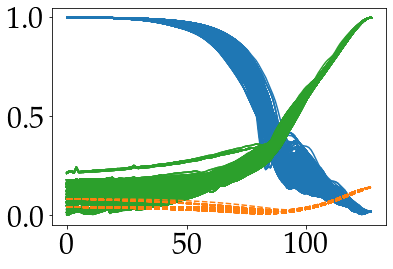

In [8]:
plt.plot(X1.T,'C0');
plt.plot(X2.T,'C2');
plt.plot(Y.T,'C1--');

In [9]:
reduc = 1

In [10]:
X1_train, X2_train, Y_train = X1[:800,::reduc], X2[:800,::reduc], Y[:800,::reduc]
X1_test, X2_test, Y_test = X1[800:,::reduc], X2[800:,::reduc], Y[800:,::reduc]

In [11]:
np.append(X1,X2,axis=1).shape

(5000, 256)

In [12]:
X_train, X_test, Y_train,  Y_test = train_test_split(np.append(X1,X2,axis=1), Y,test_size=.2)


In [13]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((4000, 256), (4000, 128), (1000, 256), (1000, 128))

In [14]:
X1_train, X1_test = X_train[:,:X_train.shape[1]//2], X_test[:,:X_train.shape[1]//2]

In [15]:
X1_train.shape, X1_test.shape

((4000, 128), (1000, 128))

In [16]:
X2_train, X2_test = X_train[:,X_train.shape[1]//2:], X_test[:,X_train.shape[1]//2:]

In [17]:
X2_train.shape, X2_test.shape

((4000, 128), (1000, 128))

In [18]:
model = keras.Sequential()
model.add(tf.keras.Input(shape=(X1_train.shape[1],)))
model.add(layers.Dense(X1_train.shape[1]))


#model.add(layers.Dense(X1_train.shape[1],activation=None,kernel_regularizer=tf.keras.regularizers.l2(1e-5)))
#model.add(layers.Dropout(.9))
#model.add(layers.Dense(XX1_train1.shape[1],activation=None,kernel_regularizer=tf.keras.regularizers.l2(1e-5)))

In [19]:
model.output_shape

(None, 128)

In [32]:
lrs[np.argmin(losses)]

0.0004832930238571752

In [33]:
model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(lrs[np.argmin(losses)]))

In [34]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               16512     
Total params: 16,512
Trainable params: 16,512
Non-trainable params: 0
_________________________________________________________________


In [35]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)

In [36]:
hist = model.fit(X2_train, Y_train, \
                 epochs=2000,verbose=0,\
                 validation_split=.2,batch_size=64,\
                 callbacks=[stop_early])

In [37]:
model.evaluate(X2_test,Y_test)

32/32 [==============================] - 0s 240us/step - loss: 3.1836e-06


3.183637318215915e-06

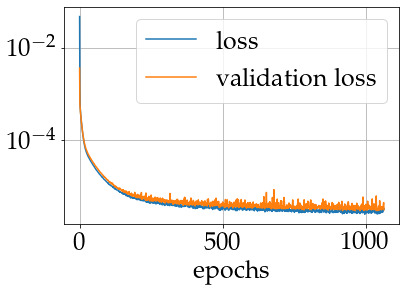

In [53]:
plt.semilogy(hist.history['loss'],label='loss')
plt.semilogy(hist.history['val_loss'],label='validation loss')
plt.xlabel('epochs')
plt.legend()
plt.grid()
plt.savefig('loss.png',dpi=300,bbox_inches='tight')


Text(0, 0.5, '$\\Delta(h^n)$')

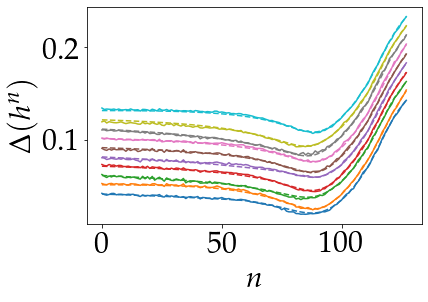

In [51]:
for i in range(10):
    plt.plot(.01*i+model.predict(X2_test[[i],:]).flatten(),'C'+str(i)+'-')
    plt.plot(.01*i+Y_test[i],'C'+str(i)+'--')
plt.xlabel('$n$')
plt.ylabel('$\Delta(h^n)$')

In [42]:
temp = np.load('../../DQPT/data/gap_DQPT_data_ham_Nspin7_Nh128_Tsig20_Nsig100.npz')


In [43]:
X1_, X2_, Y_ = temp['sigmaGS'], temp['sigmax'], temp['Gap']


In [44]:
from mpl_toolkits.mplot3d import Axes3D


In [47]:
column_names = []
for num in np.arange(1,11):
    column_names += ['A'+str(num)]
    

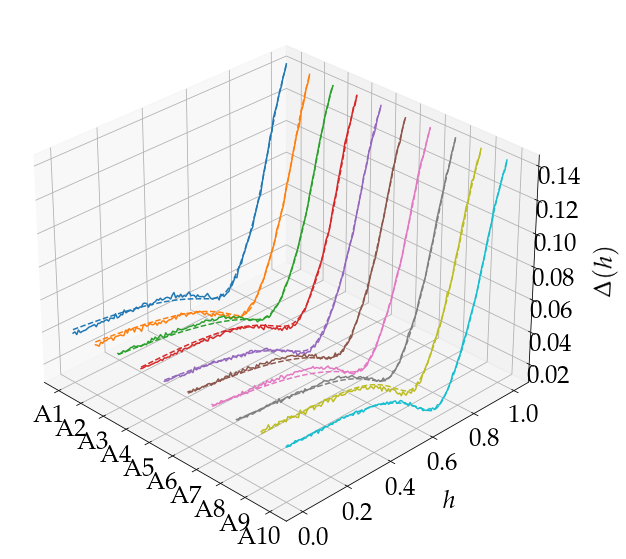

In [55]:
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111, projection='3d')
for i in range(10):
    ax.plot(i*np.ones(128),np.linspace(0,1,128),model.predict(X2_[[i],:]).flatten(),'C'+str(i)+'-')
    ax.plot(i*np.ones(128),np.linspace(0,1,128),Y_[i],'C'+str(i)+'--')
#ax.view_init(20, 359)
ax.view_init(30, 315)
ax.xaxis.set_ticks(np.arange(10))
ax.xaxis.set_ticklabels(column_names)
ax.set_ylabel('$h$',labelpad=20)
ax.set_zlabel('$\Delta(h)$',labelpad=20)
plt.savefig('predictions.png',dpi=300,bbox_inches='tight',transparent=True)

In [175]:
df_diag1 = pd.DataFrame(data=temp['hamiltonian'].T,index=np.arange(1,129),columns=column_names)

In [176]:
df_diag2 = pd.DataFrame(data=np.array([24., 16., 12., 12., 16., 16.,  4., 12., 20., 12.,  8.,  8., 20.,
       20.,  8., 16.,  8.,  8., 20., 28.,  0.,  8., 12., 28.,  4.,  4.,
       16., 24.,  4., 12., 16., 32.,  8.,  8.,  4., 12., 16., 24., 12.,
       28., 12., 12.,  8., 16., 28., 36., 24., 40.,  8., 16., 28., 44.,
       16., 32., 36., 60., 12., 20., 32., 48., 28., 44., 48., 72., 16.,
        8., 12., 12.,  8.,  8.,  4., 12., 12.,  4.,  8.,  8., 12., 12.,
        8., 16., 16., 16., 36., 44.,  8., 16., 28., 44., 12., 12., 32.,
       40., 12., 20., 32., 48.,  8.,  8., 12., 20., 16., 24., 20., 36.,
       12., 12., 16., 24., 28., 36., 32., 48., 24., 32., 52., 68., 32.,
       48., 60., 84., 28., 36., 56., 72., 44., 60., 72., 96.]),index=np.arange(1,129),columns=['B1'])

In [177]:
df_diag = pd.concat([df_diag1,df_diag2],axis=1)


In [178]:
df_diag.to_csv('Hamiltonian_diagonals')


$\frac{dh(t)}{dt}=a\Delta^\alpha(h(t))$

$h(t)=a\int \Delta^\alpha(h(t))+C$ 

$h(0)=1$ -> a

$h(T)=0$ -> C

discrete

$\Delta t_i = C\Delta_i^{-\alpha}$, $\alpha>0$

$\sum_i\Delta t_i=T$

$\rightarrow C=\frac{T}{\sum_i\Delta_i^{-\alpha}}$

In [18]:
#grid search

In [28]:
def loss(lr,lam,X_train,X_test):
    model = keras.Sequential()
    model.add(tf.keras.Input(shape=(X_train.shape[1],)))
    model.add(layers.Dense(X_train.shape[1],\
                           activation=None,\
                           kernel_regularizer=tf.keras.regularizers.l2(lam)))
    
    model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(lr))
    stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)
    model.fit(X_train, Y_train, \
              epochs=500,verbose=0,\
              validation_split=.2,batch_size=64, \
              callbacks=[stop_early])
    return model.evaluate(X_test,Y_test)

In [29]:
lrs = np.logspace(-3,-4,20)
lams = [0]
losses = np.zeros((len(lrs),len(lams)))

In [30]:
for ilrs,lr in enumerate(lrs):
    for ilam,lam in enumerate(lams):
        print(lr,lam)
        %time losses[ilrs,ilam] = loss(lr,lam,X1_train,X1_test)

0.001 0
32/32 [==============================] - 0s 236us/step - loss: 8.0125e-06
CPU times: user 23.5 s, sys: 3.25 s, total: 26.8 s
Wall time: 19.4 s
0.0008858667904100823 0
32/32 [==============================] - 0s 235us/step - loss: 7.9274e-06
CPU times: user 20.9 s, sys: 2.83 s, total: 23.8 s
Wall time: 17 s
0.0007847599703514615 0
32/32 [==============================] - 0s 235us/step - loss: 9.5432e-06
CPU times: user 23.6 s, sys: 3.23 s, total: 26.8 s
Wall time: 19.2 s
0.0006951927961775605 0
32/32 [==============================] - 0s 232us/step - loss: 9.2114e-06
CPU times: user 23.7 s, sys: 3.2 s, total: 26.9 s
Wall time: 19.3 s
0.0006158482110660267 0
32/32 [==============================] - 0s 261us/step - loss: 1.4752e-05
CPU times: user 23.7 s, sys: 3.16 s, total: 26.9 s
Wall time: 19.3 s
0.000545559478116852 0
32/32 [==============================] - 0s 238us/step - loss: 6.7960e-06
CPU times: user 23.5 s, sys: 3.18 s, total: 26.7 s
Wall time: 19.3 s
0.0004832930238571

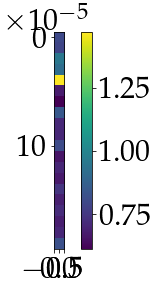

In [31]:
plt.imshow(losses)
plt.colorbar()